<a href="https://colab.research.google.com/github/NguyenTien-beep/My_Project/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from scipy.stats import chi2_contingency, f_oneway
import statsmodels.api as sm

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Load data
print("="*70)
print("LOADING DATA")
print("="*70)
df = pd.read_excel('/content/hvn30full.xlsx', sheet_name='hvn30')
print(f"\n✅ Data loaded successfully!")
print(f"   Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
df.info()


LOADING DATA


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)



✅ Data loaded successfully!
   Shape: 68516 rows × 13 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68516 entries, 0 to 68515
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ticker     68516 non-null  object        
 1   Time       68516 non-null  datetime64[ns]
 2   foredir    68516 non-null  int64         
 3   close      68516 non-null  float64       
 4   HL         68516 non-null  float64       
 5   LO         68516 non-null  float64       
 6   variation  68516 non-null  float64       
 7   vnic       68516 non-null  float64       
 8   vnipc      68516 non-null  float64       
 9   ma7        68515 non-null  float64       
 10  ma14       68516 non-null  float64       
 11  ma21       68516 non-null  float64       
 12  sd7        68516 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 6.8+ MB


1. Import Libraries & Load Data


Target Variable Distribution per Ticker:
foredir  Down    Up
ticker             
BID      1046   794
BVH      1642  1347
CTG      1775  1200
FPT      2037  1574
GAS      1246  1019
HDB       470   387
HPG      1857  1524
KDH      1719  1114
MBB      1423   978
MSN      1721  1175
MWG       910   821
NVL       594   518
PDR      1529  1044
PLX       559   480
PNJ      1711  1332
POW       354   251
REE      2917  2133
SBT      1989  1330
SSI      2030  1570
STB      2264  1456
TCB       402   360
TCH       569   604
TPB       428   361
VCB      1663  1324
VHM       428   344
VIC      1984  1440
VJC       592   484
VNM      2278  1560
VPB       487   470
VRE       472   426

📊 Total: Down=39096, Up=29420


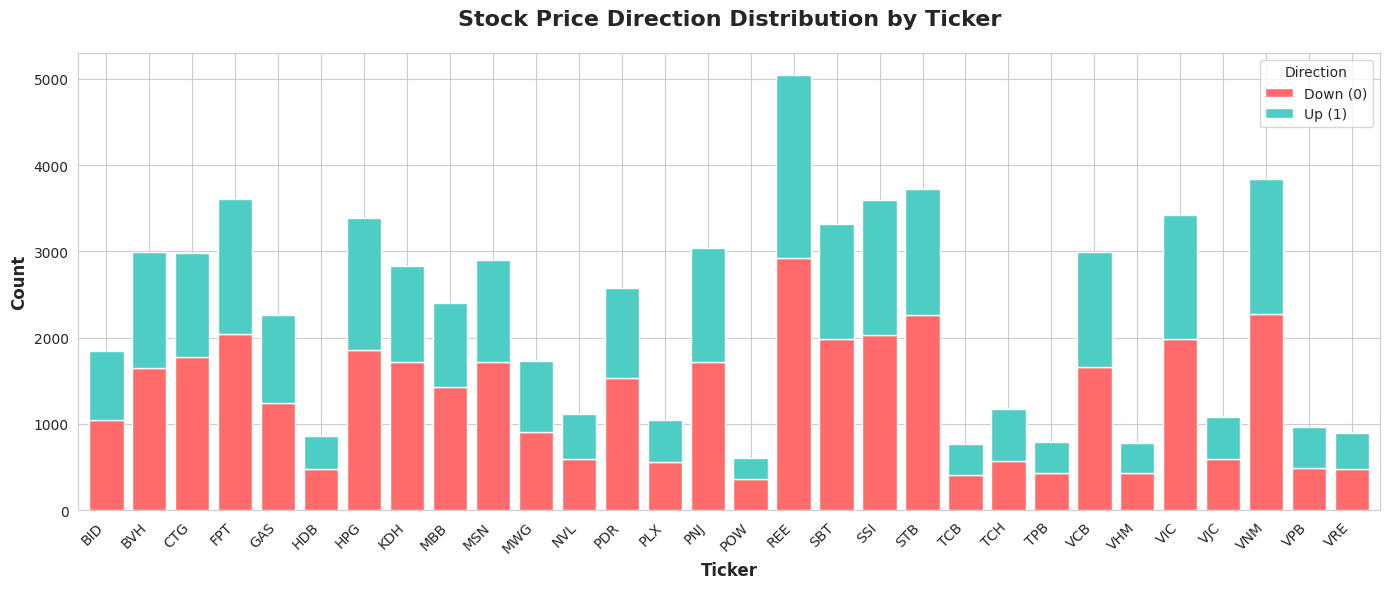

In [3]:
# Analyze target variable distribution by ticker
foredir_counts = df.groupby('ticker')['foredir'].value_counts().unstack(fill_value=0)
foredir_counts.rename(columns={0: 'Down', 1: 'Up'}, inplace=True)
foredir_counts.to_csv('foredir_counts_per_ticker.csv')

print("Target Variable Distribution per Ticker:")
print(foredir_counts)
print(f"\n📊 Total: Down={foredir_counts['Down'].sum()}, Up={foredir_counts['Up'].sum()}")

# Visualize distribution
fig, ax = plt.subplots(figsize=(14, 6))
foredir_counts.plot(kind='bar', stacked=True, ax=ax, color=['#FF6B6B', '#4ECDC4'], width=0.8)
ax.set_title('Stock Price Direction Distribution by Ticker', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Ticker', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.legend(title='Direction', labels=['Down (0)', 'Up (1)'], fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


2. Exploratory Data Analysis (EDA)
2.1 Target Variable Distribution

📊 Analyzing feature distributions by target variable...



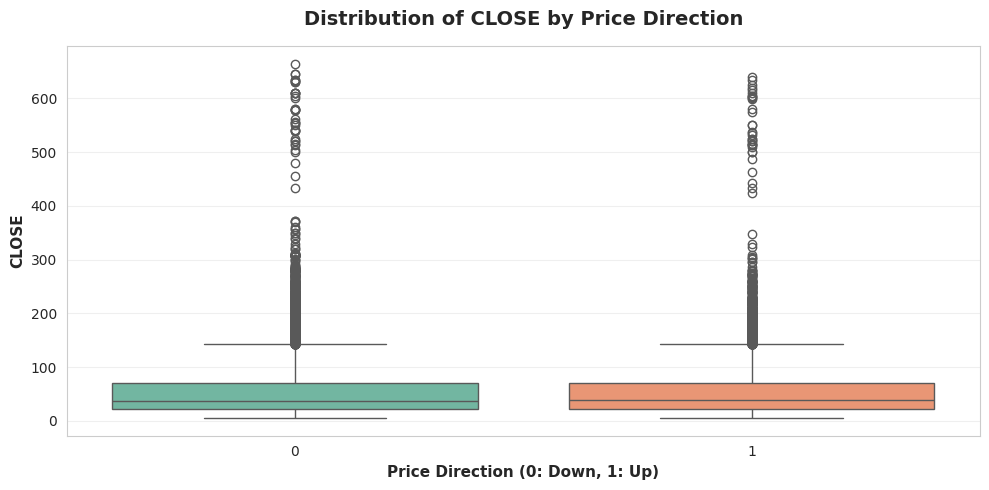

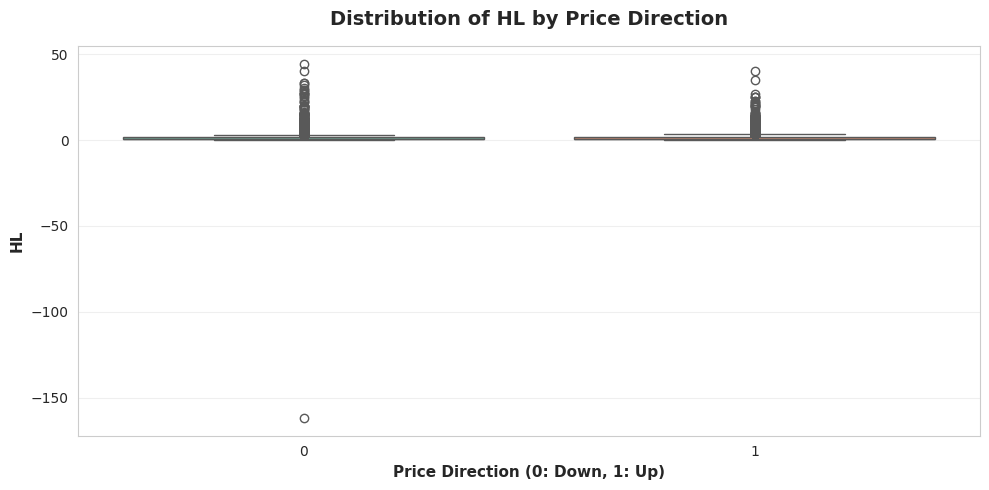

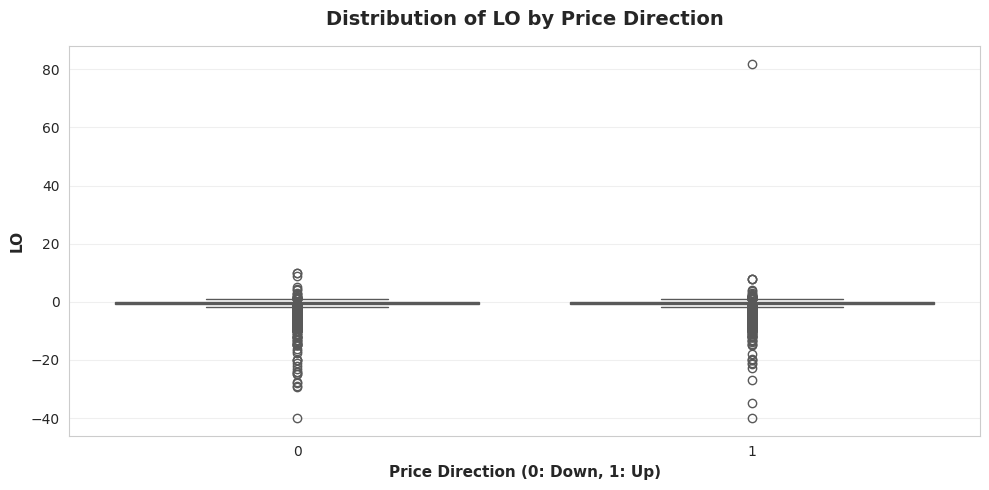

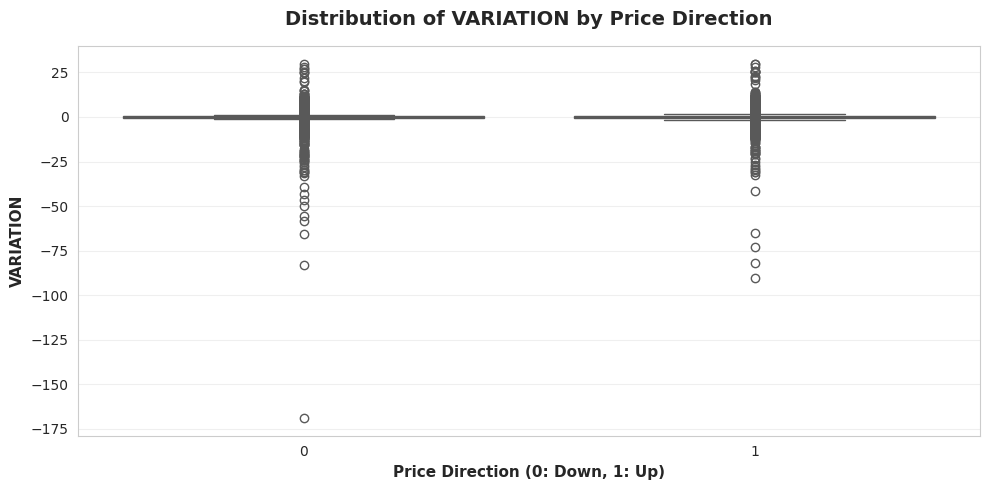

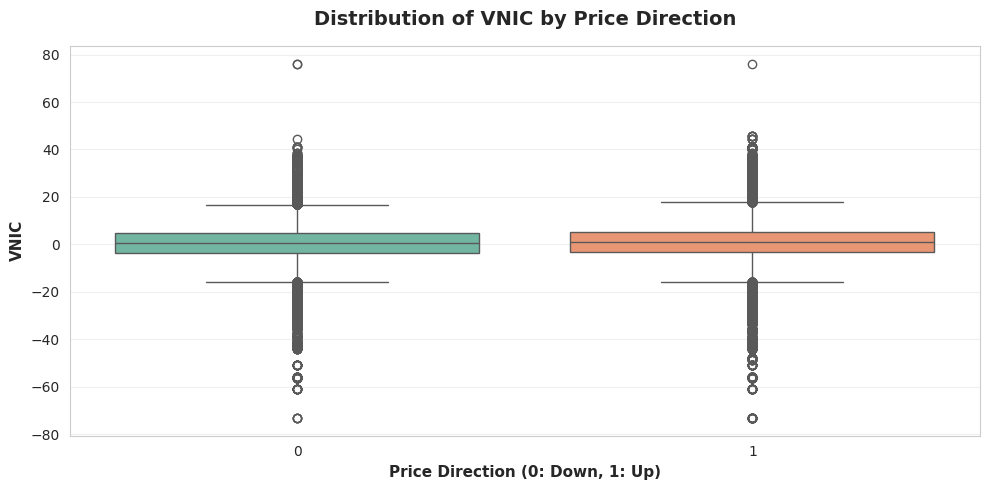

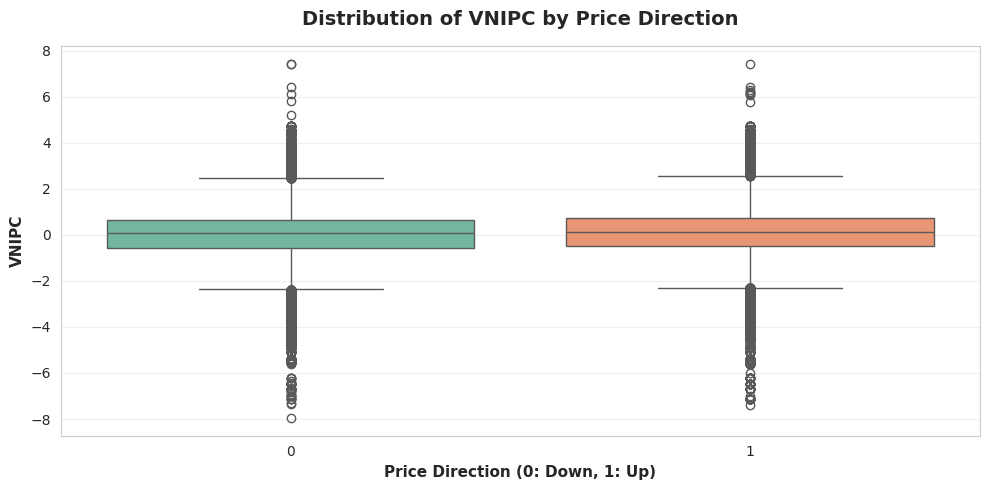

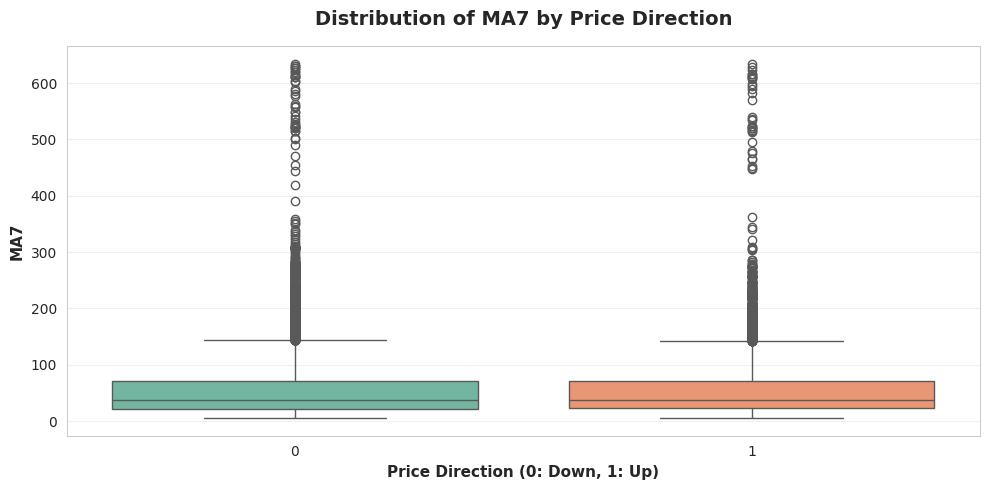

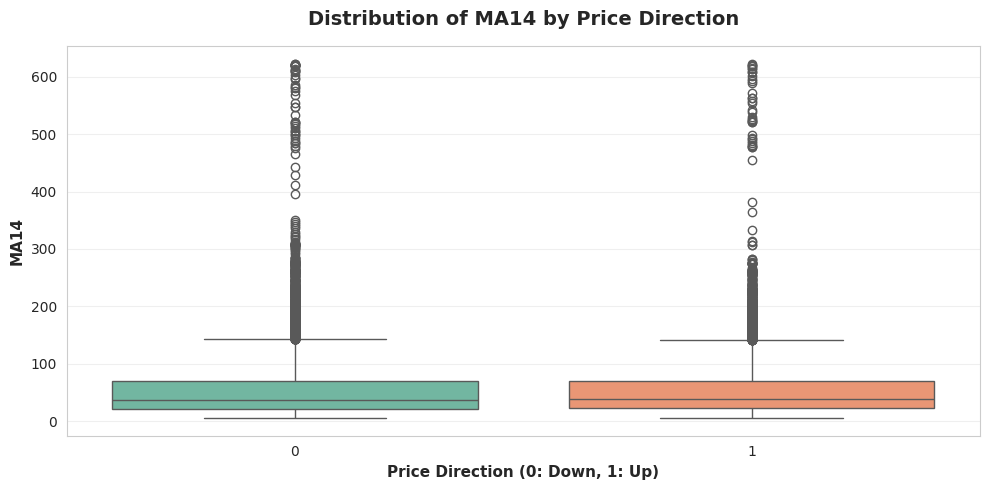

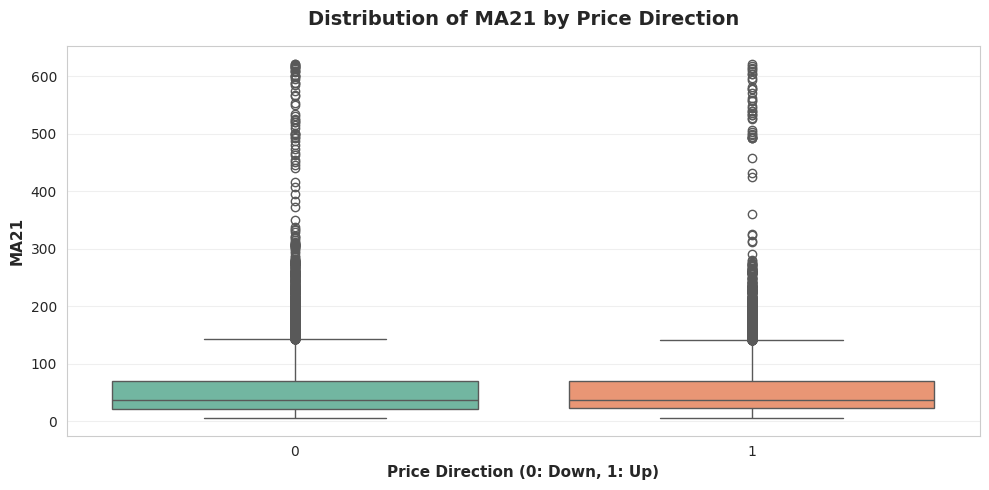

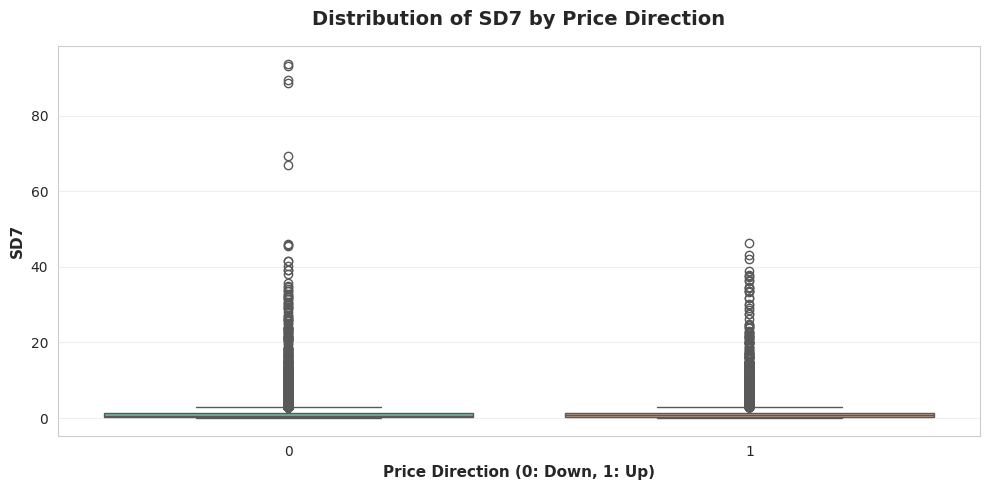

✅ Feature distribution analysis completed!


In [4]:
# Box plots for key features
features_to_plot = ['close', 'HL', 'LO', 'variation', 'vnic', 'vnipc', 'ma7', 'ma14', 'ma21', 'sd7']

print("📊 Analyzing feature distributions by target variable...\n")

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x='foredir', y=feature, data=df, hue='foredir', palette='Set2', legend=False, ax=ax)
    ax.set_title(f'Distribution of {feature.upper()} by Price Direction',
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Price Direction (0: Down, 1: Up)', fontsize=11, fontweight='bold')
    ax.set_ylabel(feature.upper(), fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Feature distribution analysis completed!")


2.2 Feature Distribution by Target

In [5]:
print("="*70)
print("DATA PREPROCESSING")
print("="*70)

# Separate features and target
X = df.drop(columns=['foredir'])
y = df['foredir']

# Convert Time to numerical format
X['Time'] = (X['Time'] - X['Time'].min()).dt.total_seconds()
print("✅ Time column converted to numerical format")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"✅ Data split: {len(X_train)} train samples, {len(X_test)} test samples")

# Identify column types
categorical_cols = ['ticker']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print(f"\n📊 Feature Types:")
print(f"   Categorical: {categorical_cols}")
print(f"   Numerical: {len(numeric_cols)} features")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("\n✅ Preprocessing pipeline created successfully!")


DATA PREPROCESSING
✅ Time column converted to numerical format
✅ Data split: 47961 train samples, 20555 test samples

📊 Feature Types:
   Categorical: ['ticker']
   Numerical: 11 features

✅ Preprocessing pipeline created successfully!


3. Data Preprocessing
3.1 Train-Test Split & Pipeline Creation

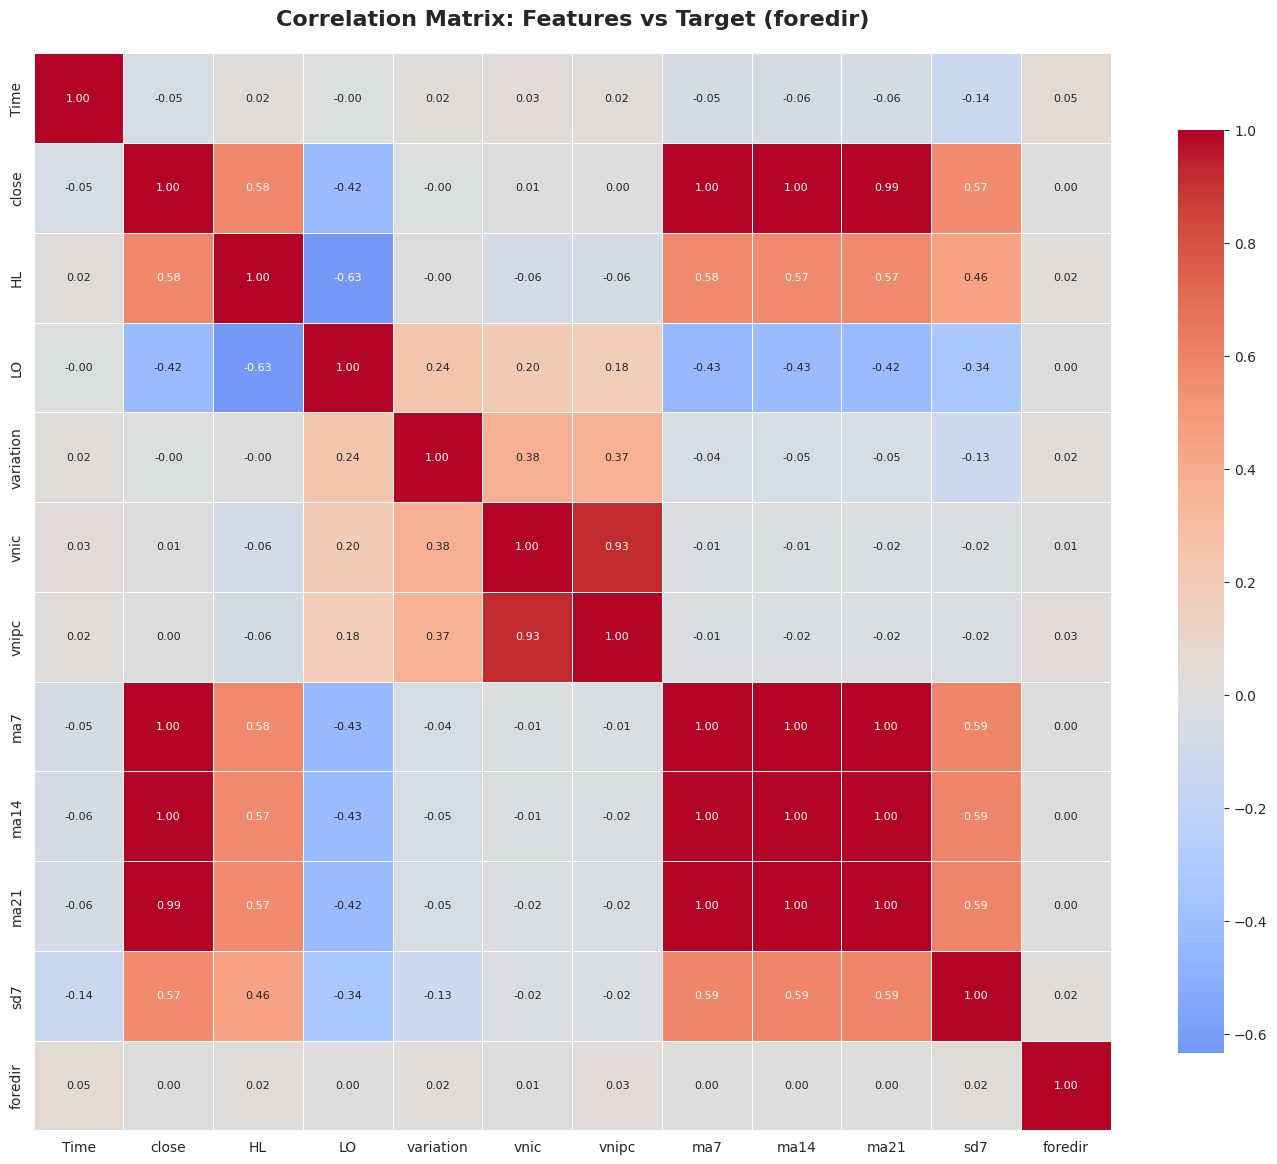


CORRELATION WITH TARGET VARIABLE (foredir)

Top Positive Correlations:
Time         0.053797
vnipc        0.026254
HL           0.022084
variation    0.021077
sd7          0.019224
Name: foredir, dtype: float64

Top Negative Correlations:
LO       0.004689
close    0.004558
ma7      0.003601
ma14     0.002764
ma21     0.001945
Name: foredir, dtype: float64


In [6]:
# Compute correlation matrix
correlation_matrix = df[numeric_cols + ['foredir']].corr()

# Visualize correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax,
            annot_kws={"fontsize": 8})
ax.set_title('Correlation Matrix: Features vs Target (foredir)',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Display top correlations with target
print("\n" + "="*70)
print("CORRELATION WITH TARGET VARIABLE (foredir)")
print("="*70)
target_corr = correlation_matrix['foredir'].drop('foredir').sort_values(ascending=False)
print("\nTop Positive Correlations:")
print(target_corr.head(5))
print("\nTop Negative Correlations:")
print(target_corr.tail(5))


3.2 Correlation Analysis

In [7]:
print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)

p_values = {}

# Chi-square test for categorical features
print("\n📊 Testing categorical features (Chi-square test)...")
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['foredir'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    p_values[col] = p_value
    print(f"   {col}: p-value = {p_value:.4e}")

# ANOVA F-test for numerical features
print("\n📊 Testing numerical features (ANOVA F-test)...")
X_with_target = X.copy()
X_with_target['foredir'] = y

for col in numeric_cols:
    group_0 = X_with_target[X_with_target['foredir'] == 0][col].dropna()
    group_1 = X_with_target[X_with_target['foredir'] == 1][col].dropna()
    f_stat, p_value = f_oneway(group_0, group_1)
    p_values[col] = p_value

# Create summary DataFrame
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-Value'])
p_values_df = p_values_df.sort_values('P-Value')
p_values_df['Significant'] = p_values_df['P-Value'] < 0.05

print("\n" + "="*70)
print("P-VALUE SUMMARY (sorted by significance)")
print("="*70)
print(p_values_df.to_string(index=False))

significant_features = p_values_df[p_values_df['Significant']]['Feature'].tolist()
print(f"\n✅ {len(significant_features)} statistically significant features (p < 0.05)")
print(f"   {', '.join(significant_features)}")


STATISTICAL SIGNIFICANCE TESTING

📊 Testing categorical features (Chi-square test)...
   ticker: p-value = 2.2783e-27

📊 Testing numerical features (ANOVA F-test)...

P-VALUE SUMMARY (sorted by significance)
  Feature      P-Value  Significant
     Time 4.277536e-45         True
   ticker 2.278327e-27         True
    vnipc 6.276882e-12         True
       HL 7.422057e-09         True
variation 3.440315e-08         True
      sd7 4.845435e-07         True
     vnic 1.550965e-02         True
       LO 2.196970e-01        False
    close 2.328605e-01        False
      ma7 3.458977e-01        False
     ma14 4.694606e-01        False
     ma21 6.106118e-01        False

✅ 7 statistically significant features (p < 0.05)
   Time, ticker, vnipc, HL, variation, sd7, vnic


3.3 Statistical Significance Testing

In [8]:
print("="*70)
print("MODEL TRAINING: LOGISTIC REGRESSION")
print("="*70)

# Create full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000, random_state=42, solver='lbfgs'))
])

# Train the model
print("\n⏳ Training model...")
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("✅ Model trained successfully!")
print(f"\n📊 Model Parameters:")
print(f"   Solver: lbfgs")
print(f"   Max iterations: 10,000")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features after preprocessing: {pipeline.named_steps['preprocessor'].transform(X_train).shape[1]}")


MODEL TRAINING: LOGISTIC REGRESSION

⏳ Training model...
✅ Model trained successfully!

📊 Model Parameters:
   Solver: lbfgs
   Max iterations: 10,000
   Training samples: 47961
   Test samples: 20555
   Features after preprocessing: 40


4. Model Training
4.1 Logistic Regression with Sklearn

MODEL ACCURACY

🎯 Accuracy: 0.5737 (57.37%)


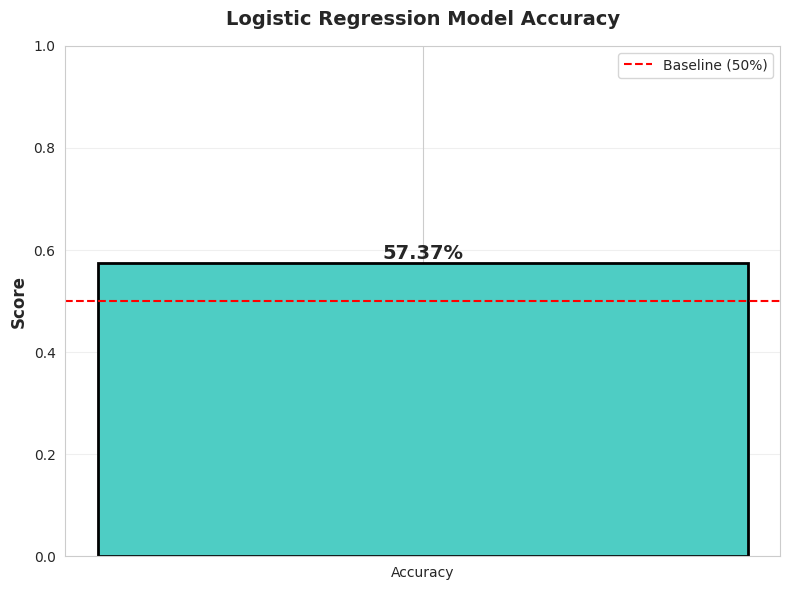

In [9]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print("="*70)
print("MODEL ACCURACY")
print("="*70)
print(f"\n🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Visualize accuracy
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Accuracy'], [accuracy], color='#4ECDC4', width=0.5, edgecolor='black', linewidth=2)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='Baseline (50%)')
ax.set_ylim(0, 1)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression Model Accuracy', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=10)

# Add value label on bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}', ha='center', va='bottom',
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


5. Model Evaluation
5.1 Accuracy Score

In [10]:
# Calculate F1 score and other metrics
from sklearn.metrics import precision_score, recall_score, classification_report

f1 = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print("="*70)
print("CLASSIFICATION METRICS")
print("="*70)
print(f"\n📊 Overall Metrics:")
print(f"   F1 Score:  {f1:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print("\n" + classification_report(y_test, predictions,
                                   target_names=['Down (0)', 'Up (1)'],
                                   digits=4))


CLASSIFICATION METRICS

📊 Overall Metrics:
   F1 Score:  0.4584
   Precision: 0.5567
   Recall:    0.5737

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

    Down (0)     0.5760    0.9587    0.7196     11729
      Up (1)     0.5310    0.0621    0.1112      8826

    accuracy                         0.5737     20555
   macro avg     0.5535    0.5104    0.4154     20555
weighted avg     0.5567    0.5737    0.4584     20555



5.2 Confusion Matrix

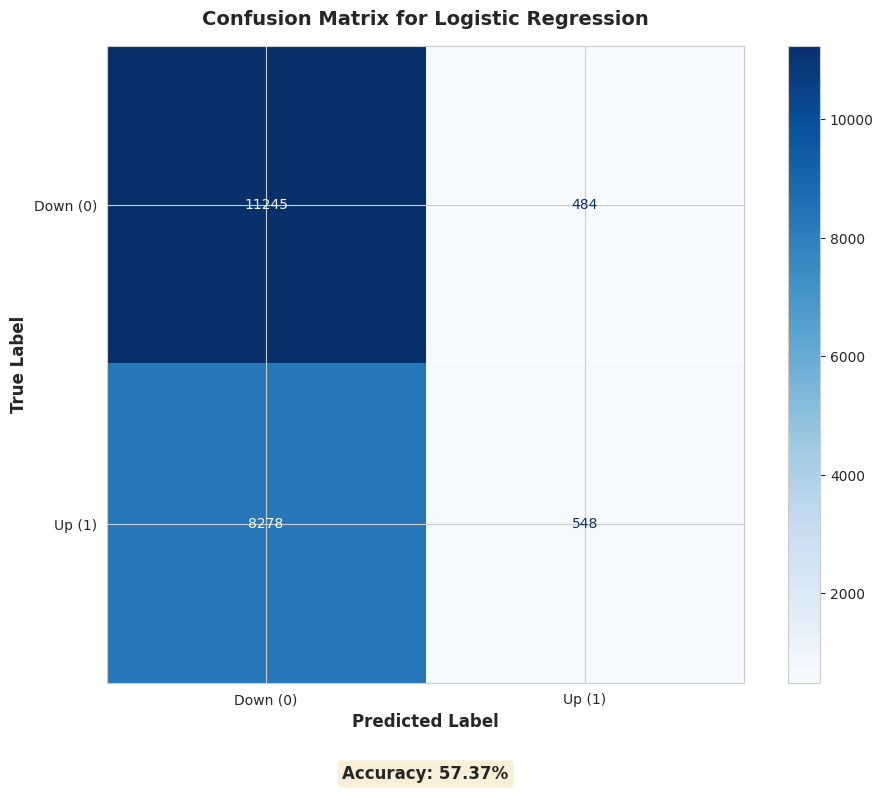


CONFUSION MATRIX BREAKDOWN

True Negatives (TN):  11,245 - Correctly predicted Down
False Positives (FP): 484 - Incorrectly predicted Up
False Negatives (FN): 8,278 - Incorrectly predicted Down
True Positives (TP):  548 - Correctly predicted Up

Total Correct: 11,793 / 20,555
Total Wrong:   8,762 / 20,555


In [11]:
# Create confusion matrix
cm = confusion_matrix(y_test, predictions, labels=pipeline.named_steps['classifier'].classes_)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=True)
ax.set_title('Confusion Matrix for Logistic Regression',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')

# Add accuracy info
accuracy_text = f'Accuracy: {accuracy:.2%}'
ax.text(0.5, -0.15, accuracy_text, transform=ax.transAxes,
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
print("\n" + "="*70)
print("CONFUSION MATRIX BREAKDOWN")
print("="*70)
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN):  {tn:,} - Correctly predicted Down")
print(f"False Positives (FP): {fp:,} - Incorrectly predicted Up")
print(f"False Negatives (FN): {fn:,} - Incorrectly predicted Down")
print(f"True Positives (TP):  {tp:,} - Correctly predicted Up")
print(f"\nTotal Correct: {tn + tp:,} / {len(y_test):,}")
print(f"Total Wrong:   {fp + fn:,} / {len(y_test):,}")


5.3 ROC Curve

ROC CURVE ANALYSIS

📈 AUC (Area Under Curve): 0.5572


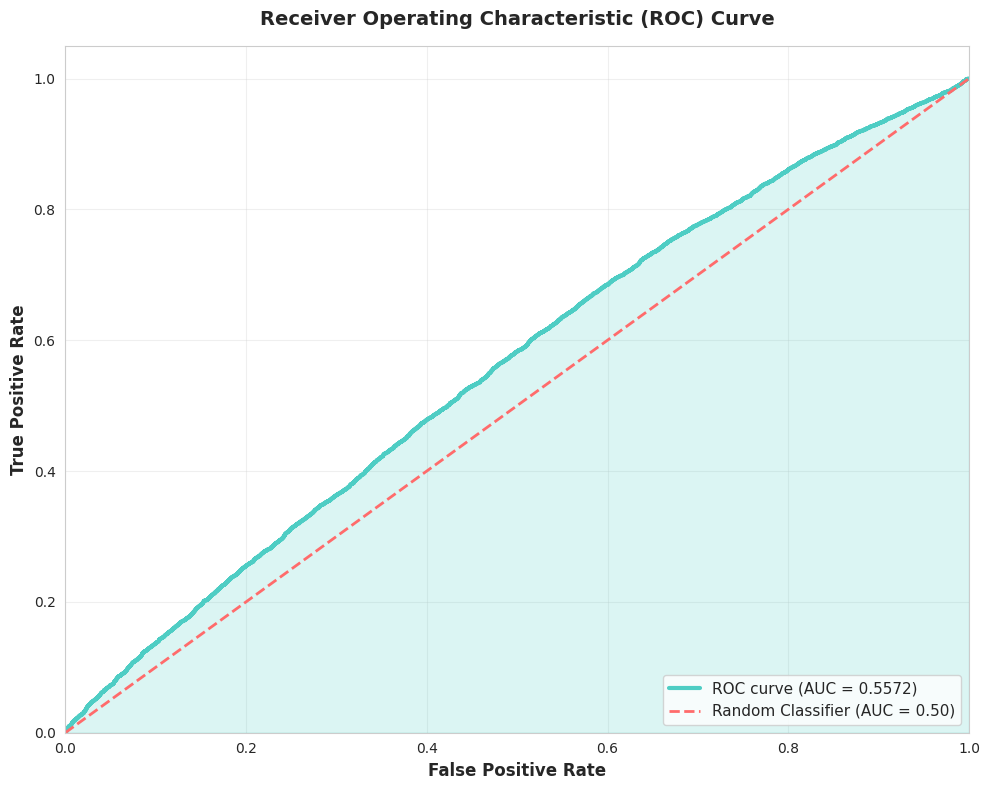


🎯 Model Performance: Poor
   The model can distinguish between Up and Down directions
   with poor discriminative ability.


In [12]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print("="*70)
print("ROC CURVE ANALYSIS")
print("="*70)
print(f"\n📈 AUC (Area Under Curve): {roc_auc:.4f}")

# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='#4ECDC4', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='#FF6B6B', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
ax.fill_between(fpr, tpr, alpha=0.2, color='#4ECDC4')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Receiver Operating Characteristic (ROC) Curve',
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation
if roc_auc >= 0.9:
    interpretation = "Excellent"
elif roc_auc >= 0.8:
    interpretation = "Very Good"
elif roc_auc >= 0.7:
    interpretation = "Good"
elif roc_auc >= 0.6:
    interpretation = "Fair"
else:
    interpretation = "Poor"

print(f"\n🎯 Model Performance: {interpretation}")
print(f"   The model can distinguish between Up and Down directions")
print(f"   with {interpretation.lower()} discriminative ability.")


In [13]:
print("="*70)
print("DETAILED LOGIT REGRESSION RESULTS (STATSMODELS)")
print("="*70)

# Prepare data for statsmodels
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

# Convert sparse matrix to dense array if needed
if hasattr(X_train_preprocessed, 'toarray'):
    X_train_preprocessed = X_train_preprocessed.toarray()

# Add constant term
X_train_with_const = sm.add_constant(X_train_preprocessed)

# Fit logistic regression using statsmodels
print("\n⏳ Fitting statsmodels Logit model...")
logit_model = sm.Logit(y_train, X_train_with_const)
result = logit_model.fit(disp=0)  # disp=0 to suppress optimization output

print("✅ Model fitted successfully!\n")
print("="*70)
print(result.summary())
print("="*70)

# Additional statistics
print("\n📊 Key Statistics:")
print(f"   Pseudo R-squared:  {result.prsquared:.6f}")
print(f"   Log-Likelihood:    {result.llf:.2f}")
print(f"   AIC:               {result.aic:.2f}")
print(f"   BIC:               {result.bic:.2f}")
print(f"   LLR p-value:       {result.llr_pvalue:.4e}")
print(f"\n✅ Model converged:   {result.mle_retvals['converged']}")


DETAILED LOGIT REGRESSION RESULTS (STATSMODELS)

⏳ Fitting statsmodels Logit model...
✅ Model fitted successfully!

                           Logit Regression Results                           
Dep. Variable:                foredir   No. Observations:                47961
Model:                          Logit   Df Residuals:                    47920
Method:                           MLE   Df Model:                           40
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                0.006885
Time:                        04:49:57   Log-Likelihood:                -32539.
converged:                       True   LL-Null:                       -32764.
Covariance Type:            nonrobust   LLR p-value:                 5.028e-71
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3580      0.057     -6.262      0.000      -0.470      -0.246
x1             